In [1]:
# # all our imports
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras import Model
# from os import listdir
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.applications.vgg16 import preprocess_input
# from keras.models import Model
# from pickle import dump
# from pickle import load
# import emoji
# import advertools as adv
# from sklearn.model_selection import train_test_split

In [2]:
# def extract_features(directory):
#     model = tf.keras.applications.VGG16()
#     model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#     print(model.summary())
#     features = dict()
#     for name in listdir(directory):
#         filename = directory + '/' + name
#         image = load_img(filename, target_size=(224, 224))
#         image = img_to_array(image)
#         image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     image = preprocess_input(image)
#     feature = model.predict(image, verbose=0)
#     image_id = name.split('.')[0]
#     features[image_id] = feature
#     return features

# directory = 'instagram_data/img'
# features = extract_features(directory)
# print('Extracted Features: %d' % len(features))
# dump(features, open('features.pkl', 'wb'))

In [3]:
# print(len(features['insta8959']))

In [4]:
# import pandas as pd
# def load_doc(filename):
#     df = pd.read_csv(filename)
#     # Remove  na values
#     df = df.dropna()
#     # Drop the first column
#     df = df.drop(df.columns[0], axis=1)
#     # Rename Image File column to image_id
#     df = df.rename(columns={"Image File": "image_id"})
#     # In the image_id column, remove the file extension
#     df['image_id'] = df['image_id'].str.replace('img/', '')
#     # keep only the emojis in the caption
#     df["Caption"] = adv.extract_emoji(df["Caption"])["emoji"]

#     # Turn the dataframe into a dictionary with the image_id as the key and the caption as the value
#     captions = dict()
#     for i in range(len(df)):
#         image_id = df.iloc[i]['image_id']
#         caption = df.iloc[i]['Caption']
#         captions[image_id] = caption

#     return captions
    

# filename = 'instagram_data/captions_csv.csv'
# descriptions = load_doc(filename)
# print(descriptions)

In [5]:
# def to_vocabulary(descriptions):
#     # build a list of all description strings
#     all_desc = set()
#     # Split the descriptions into words and add them to the set
#     for key in descriptions.keys():
#         [all_desc.update(d.split()) for d in descriptions[key].split()]
#     return all_desc
 
# # summarize vocabulary
# vocabulary = to_vocabulary(descriptions)
# print(vocabulary)
# print(len(vocabulary))

In [6]:
# def save_descriptions(descriptions, filename):
# 	lines = list()
	
# 	for key, desc in descriptions.items():
# 		new_desc = ""
# 		if desc == []:
# 			continue
# 		else:
# 			for element in desc:
# 				new_desc += element
# 			lines.append(key + " " + new_desc)

# 	data = '\n'.join(lines)
# 	file = open(filename, 'w')
# 	file.write(data)
# 	file.close()

# save_descriptions(descriptions, 'descriptions.txt')

In [7]:
# desc = []
# file = open("descriptions.txt")
# for element in file:
#     identifier = element.split(" ")[0]
#     desc.append(identifier)
# train, test = train_test_split(desc, test_size = 0.20, random_state = 10)
# print(train)
# len(train)

In [8]:
import os
import pickle
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from sklearn.model_selection import train_test_split

2024-03-01 14:57:29.222010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
base_direct = "archive"

In [10]:
vgg = VGG16()

model = Model(inputs = vgg.inputs, outputs = vgg.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# base_direct = '/archive'  # Update with the correct base directory path
# directory = os.path.join(base_direct, "Images")

# # Check if the directory exists
# if os.path.exists(directory):
#     # Proceed with your code to process images
#     for img_name in os.listdir(directory):
#         img_path = os.path.join(directory, img_name)
#         # Process each image...
# else:
#     print(f"Directory '{directory}' not found.")

In [12]:
features = {}
directory = os.path.join(base_direct, "Images")

for img_name in os.listdir(directory):
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size = (224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose = 0)
    image_id = img_name.split(".")[0]
    features[image_id] = feature

In [ ]:
pickle.dump(features, open("features.pkl", "wb"))
with open("features.pkl", "rb") as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(base_direct, 'captions.txt')) as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in captions_doc.split("\n"):
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split(".")[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)
print(len(mapping))

8091


In [ ]:
def clean(mapping):
    for id, captions in mapping.items():
        for x in range(len(captions)):
            caption = captions[x]
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            caption = " ".join(caption.split())
            caption = " ".join([word for word in caption.split() if len(word)>1])
            captions[x] = caption
mapping['1000268201_693b08cb0e']
clean(mapping)
mapping['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
all_cap = []
for key in mapping:
    for caption in mapping[key]:
        all_cap.append(caption)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cap)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8483

In [ ]:
max_length = max(len(caption.split()) for caption in all_cap)
max_length

33

In [ ]:
#train test split
image_ids = list(mapping.keys())
train, test = train_test_split(image_ids, test_size=0.2, random_state=42)

In [ ]:
#getting batch, for sequence to sequence model
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for c in captions:
                seq = tokenizer.texts_to_sequences([c])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# epochs = 20
# batch_size = 64
# steps = len(train) // batch_size

# generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)

In [ ]:
# model.save('/best_model.keras')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('best_model.keras')

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_direct, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(new_model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
group of girls stands wearing jean skirts and superman shirts
group of women with black shirts
"four women in front of odeon wear similar black pink and white superman type shirts and jean skirts ."
"girls in matching outfits one holding inflatable toy outside of odeon building ."
girls walking in the street on sunny day


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x1x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShad

--------------------Predicted--------------------
startseq woman and woman are sitting on the street with cellphone and another woman and black and white and black and black and black and black and black and black and black and black


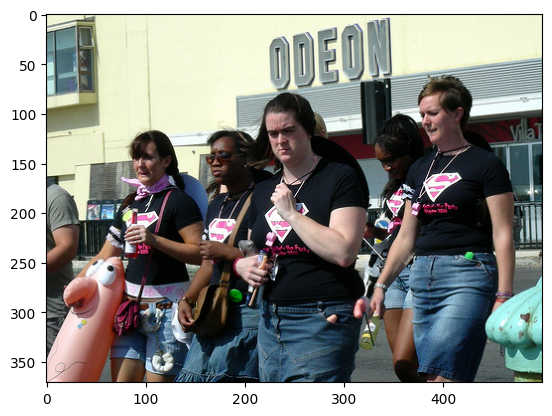

In [ ]:
generate_caption("3002448718_a478c64fb4.jpg")